In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import colors as colors
from matplotlib import animation
from matplotlib import colorbar
import pandas as pd
import math
from sklearn import preprocessing
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade mapclassify
 
import geopandas

     |████████████████████████████████| 1.0MB 17.4MB/s 
     |████████████████████████████████| 15.3MB 265kB/s 
     |████████████████████████████████| 6.5MB 42.2MB/s 
     |████████████████████████████████| 225kB 17.5MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=308b4490e65b98e9c9ed5e4e3d17e64923ee41de523316e808b4662461f1ea33
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp
Requirement already up-to-date: shapely in /usr/local/lib/python3.7/dist-packages (1.7.1)
Requirement already up-to-date: descartes in /usr/local/lib/python3.7/dist-packages (1.1.0)


In [ ]:
class SOM:
  def __init__(self, data, dim, features, n_iter=1000, alpha=0.05, normalize_data=True):
    self.net_dim = dim
    self.alpha = alpha
    self.sigma = max(self.net_dim[0], self.net_dim[1]) / 2
    self.t_const =  n_iter / math.log(self.sigma)
    self.n_iter = n_iter
    self.data = data
    self.norm = normalize_data
    self.features = features
    self.preprocess()
    self.net = np.random.random((self.net_dim[0], self.net_dim[1], len(self.features)))
    self.net_const = self.net.copy()
    

  def resetNet(self):
    self.net = self.net_const

  def preprocess(self):
    cols = self.data.columns
    self.data = pd.DataFrame(self.data, columns=cols)
    if self.norm:
      self.data[self.features] = preprocessing.MinMaxScaler().fit_transform(self.data[self.features])

  def getFeaturesByYear(self, year):
    return self.data.loc[self.data['Year'] == year]

  def distance(self, w, t):
    dist = 0
    for i in range(len(self.features)):
      dist += (w[i] - t[i])**2
    return dist

  def find_bmu(self, t):
    bmu_idx = [0, 0]
    min_dist = math.inf

    for x in range(self.net_dim[0]):
      for y in range(self.net_dim[1]):
        w = self.net[x, y, :] # transpose of weight vector
        dist = self.distance(w, t)
        if dist < min_dist:
          min_dist = dist
          bmu_idx = [x, y]

    bmu = self.net[bmu_idx[0], bmu_idx[1], :]
    return (bmu, bmu_idx)

  def decay(self, i):
    decay_rad = self.sigma*math.exp(-i/self.t_const)
    decay_lr = self.alpha*math.exp(-i/self.n_iter)
    return decay_rad, decay_lr

  def influence(self, dist, rad):
    return math.exp(-dist / (2 * (rad**2)))

  def som(self, i, data=pd.DataFrame([])):
    if data.empty:
      data = self.data
    self.resetNet()
    col = ['darkblue', 'mediumblue', 'slateblue', 'rebeccapurple', 'darkmagenta','mediumvioletred','indianred', 'darkorange', 'orange', 'gold']
    cmap = colors.ListedColormap(col)
    # cmap = plt.get_cmap('plasma')
    norm = colors.Normalize(vmin=0, vmax=1)
    ims = []
    for i in range(self.n_iter):
      t = data.sample()[self.features].to_numpy()[0, :] # transpose of training vector
      bmu, bmu_idx = self.find_bmu(t)
      rad, lr = self.decay(i)
      for x in range(self.net_dim[0]):
        for y in range(self.net_dim[1]):
          w = self.net[x, y, :] # transpose of weight vector
          bmu_dist = ((bmu_idx[0] - x))**2 + ((bmu_idx[1] - y))**2
          if bmu_dist <= rad**2:
            inf = self.influence(bmu_dist, rad)
            self.net[x, y, :] = w + (lr * inf * (t - w))
      # sif i % 10 == 0:
    output = np.sum(self.net, axis=2)  
    ims.append([plt.imshow((output/np.max(output)), interpolation=None, cmap=cmap, norm=norm)])
    plt.show()
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cb1 = colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    plt.show()
    return ims[-1]

  def somByYear(self, step=5):
    noOfYears = self.data['Year'].unique().shape[0]
    r = math.floor(noOfYears/step)
    min = self.data['Year'].min()
    for i in range(r+1):
      data = self.getFeaturesByYear(min+i*step)
      print(min+i*step)
      self.som(data)
      self.visualizeWorld(data)
    plt.show()

  def visualizeWorld(self, data):
    ''' reference: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b '''
    # fig, ax = plt.subplots()
    bmu_country = []
    for idx, row in data.iterrows():
      t = row[self.features]
      bmu, bmu_idx = self.find_bmu(t)
      bmu_country.append(np.sum(bmu))
    data.loc[: , 'BMU'] = bmu_country
    # data['BMU'] = bmu_country
    col = ['darkblue', 'mediumblue', 'slateblue', 'rebeccapurple', 'darkmagenta','mediumvioletred','indianred', 'darkorange', 'orange', 'gold']
    cmap = colors.ListedColormap(col)
    # cmap = plt.get_cmap('plasma')
    norm = colors.Normalize(vmin=0, vmax=2)
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 
    
    # rename the columns so that we can merge with our data
    world.columns=['pop_est', 'continent', 'name', 'Country Code', 'gdp_md_est', 'geometry']
    merge=pd.merge(world, data,on='Country Code')
    location=pd.read_csv('country_centroids_az8.csv')
    location = location[['name', 'Longitude', 'Latitude']]
    location['name'].replace({'United States':'United States of America'}, inplace=True)
    merge=merge.merge(location,on='name')
    merge.plot(column='BMU',
           figsize=(20, 10),
           legend=True,cmap=cmap, norm=norm)
    plt.title('Life Expectancy Around the World',fontsize=25)
    plt.show()



In [ ]:
data = pd.read_csv('Life Expectancy at Birth.csv',
                   sep=",", encoding='cp1252')
data = data.loc[(data['Income Group'] != -1) & (data['Life Expectancy'] != -1)]

1960


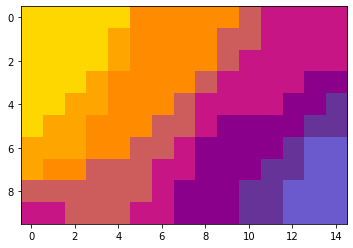

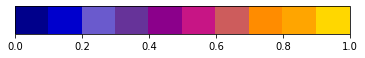

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


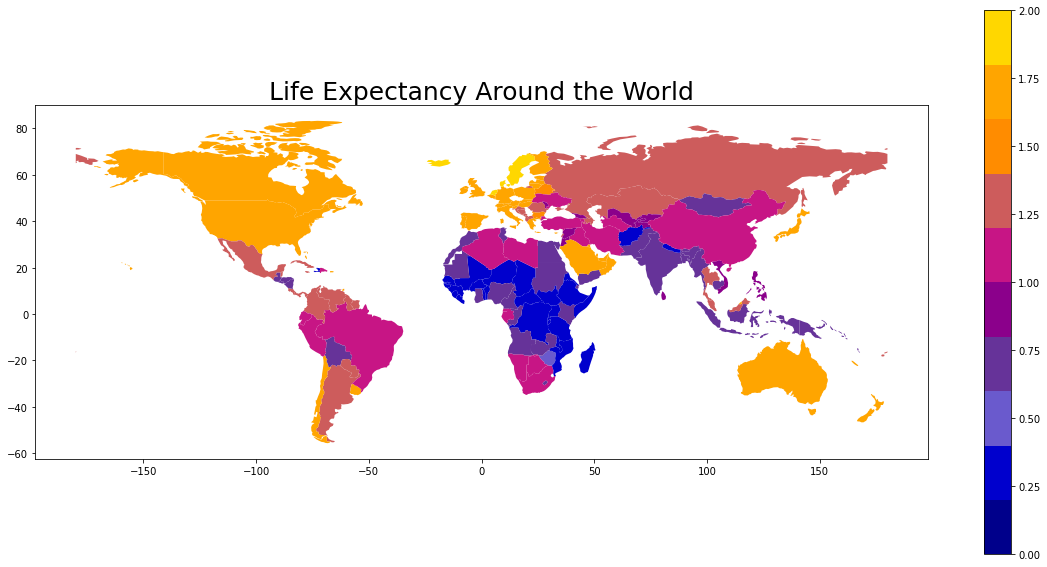

1965


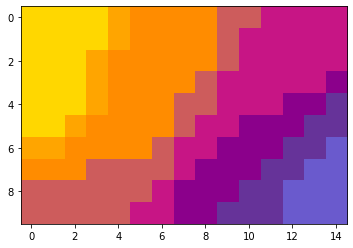

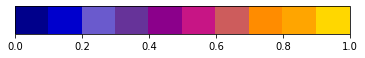

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


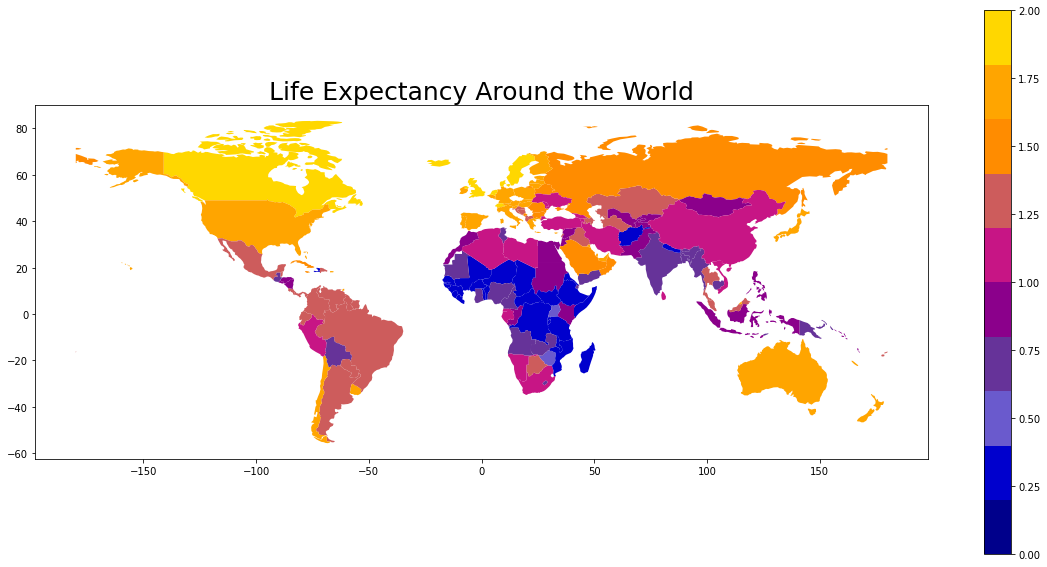

1970


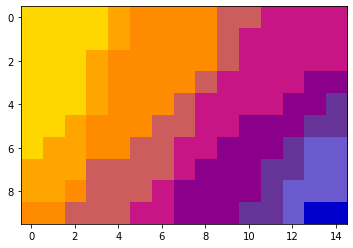

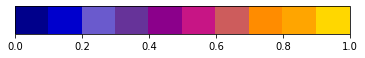

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


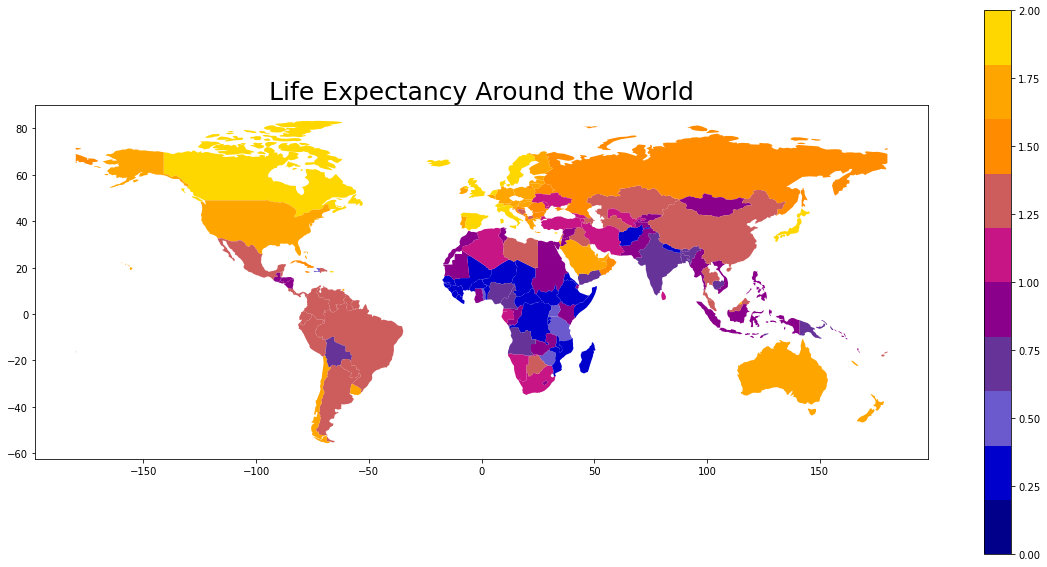

1975


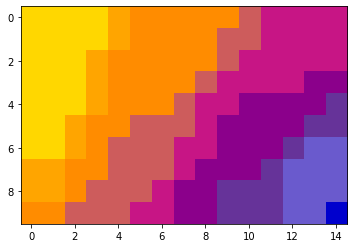

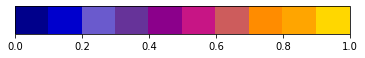

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


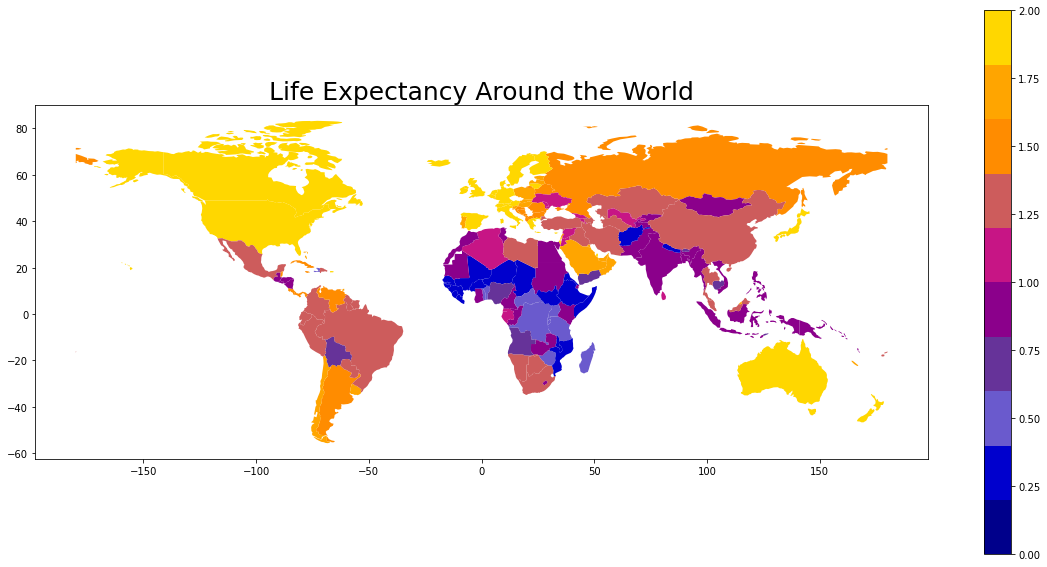

1980


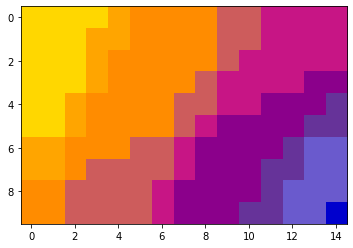

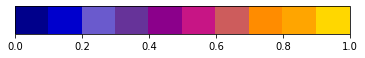

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


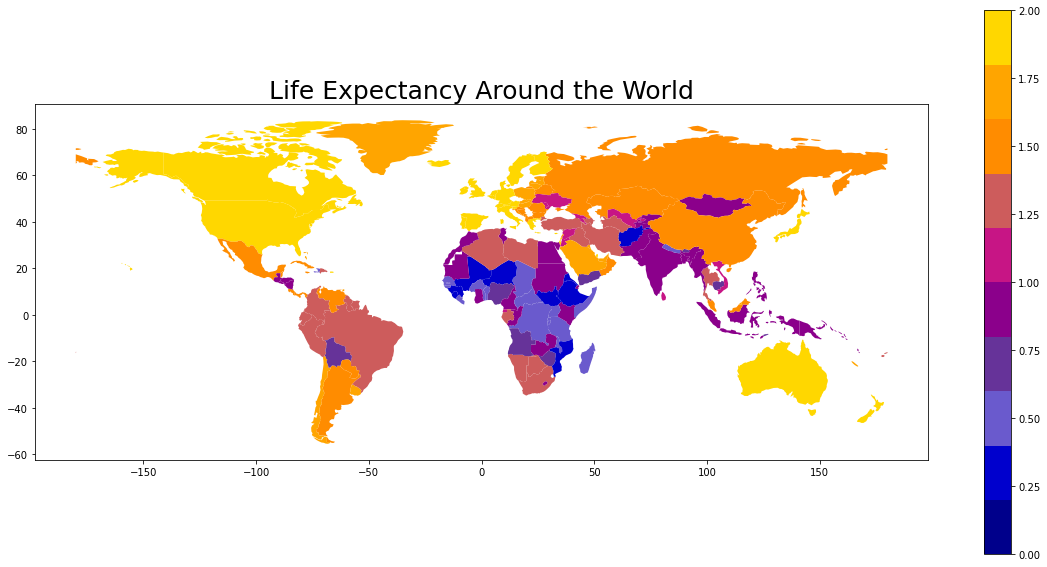

1985


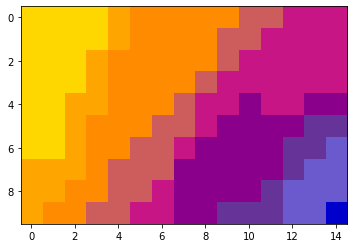

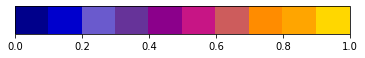

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


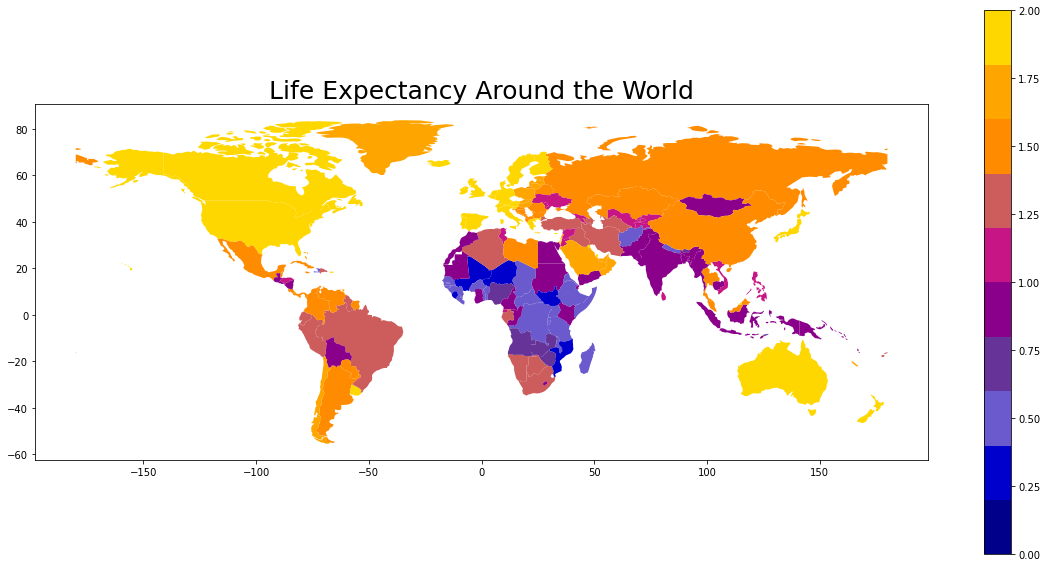

1990


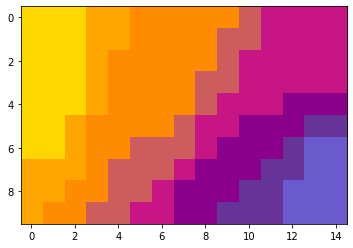

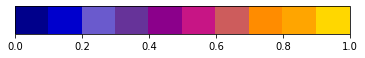

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


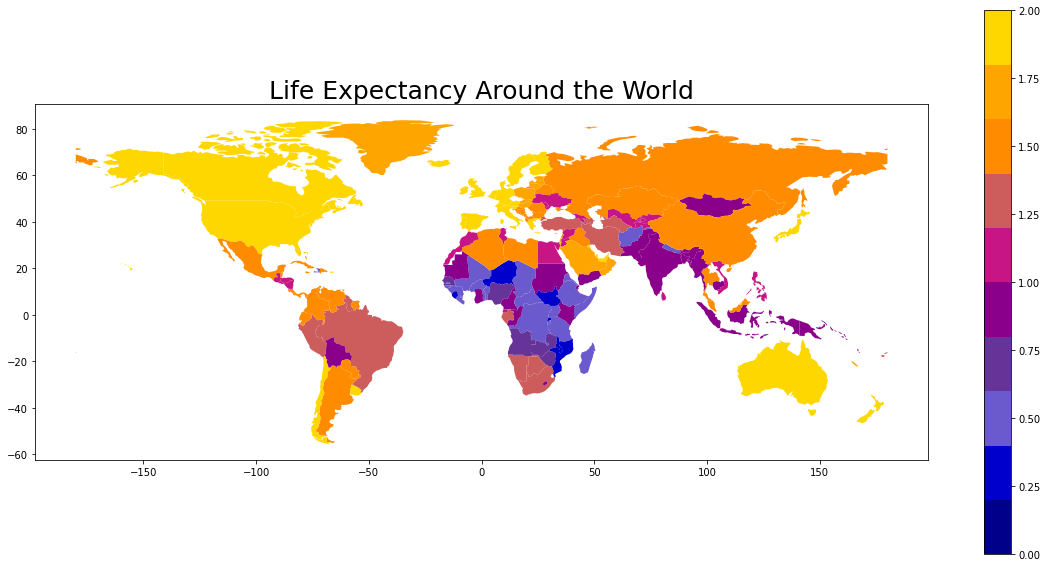

1995


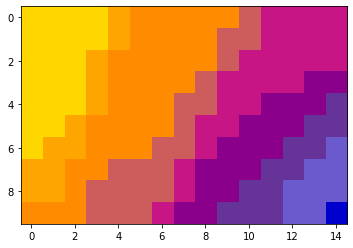

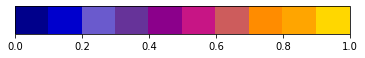

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


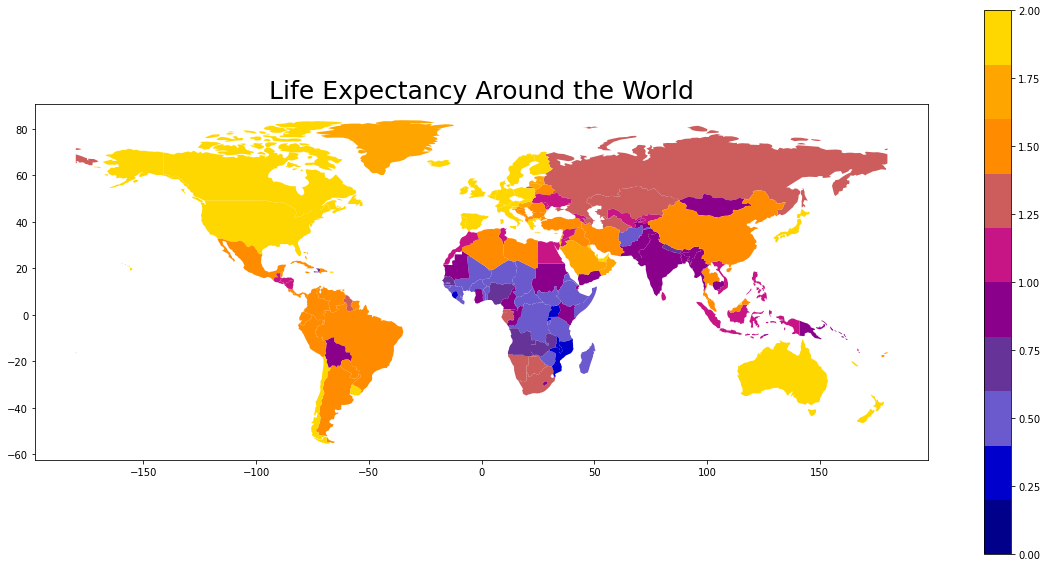

2000


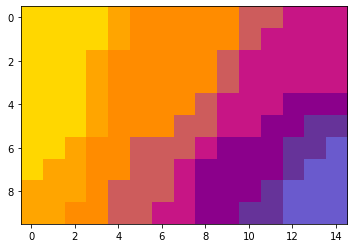

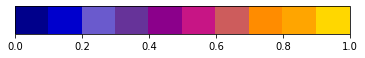

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


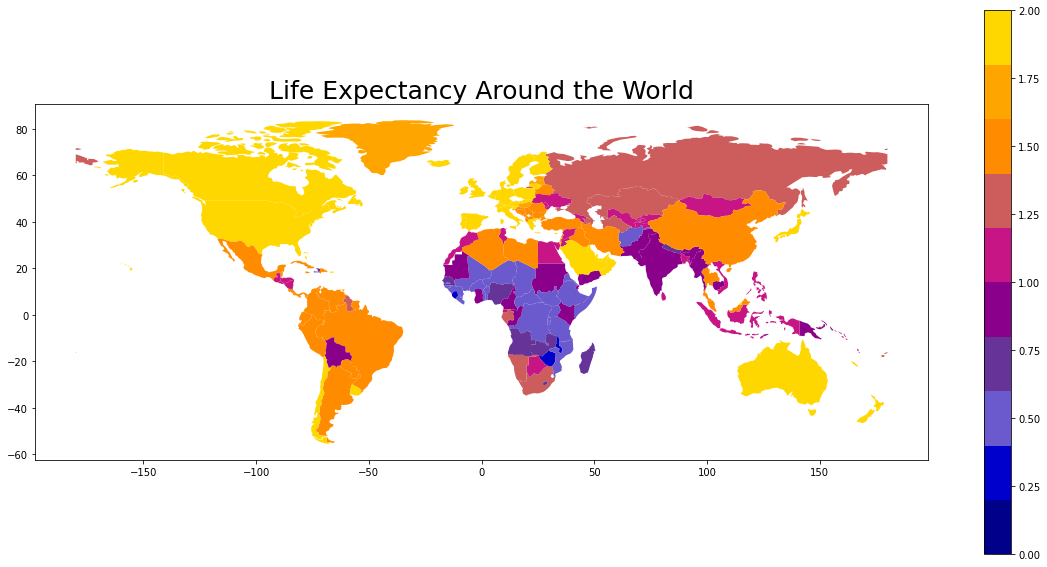

2005


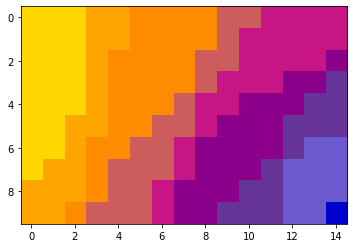

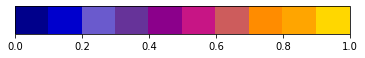

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


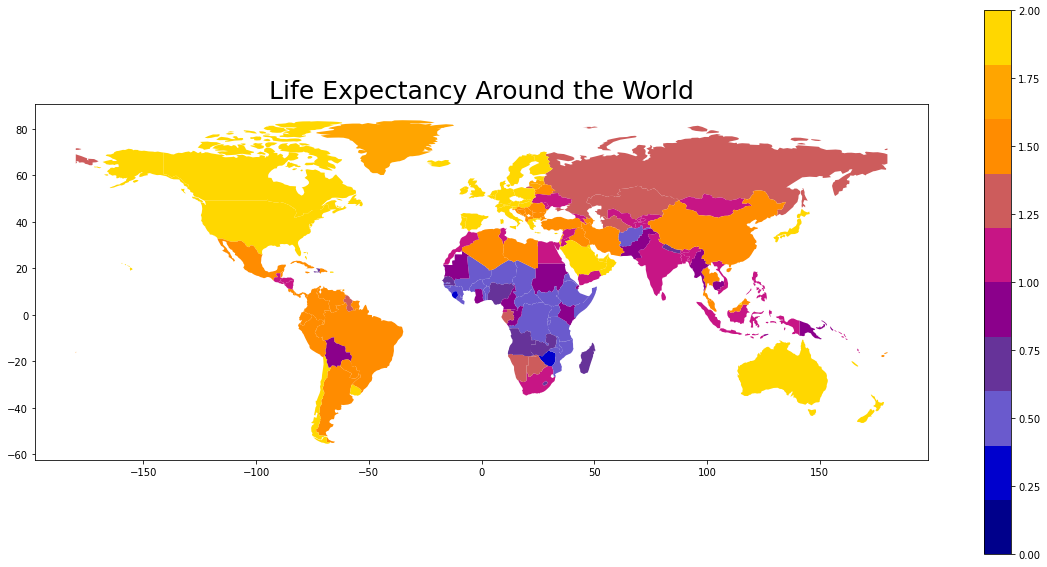

2010


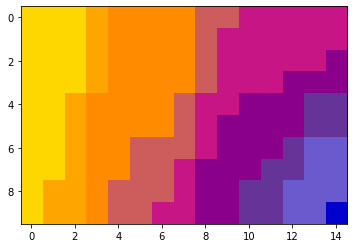

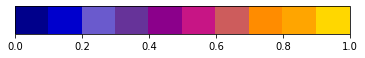

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


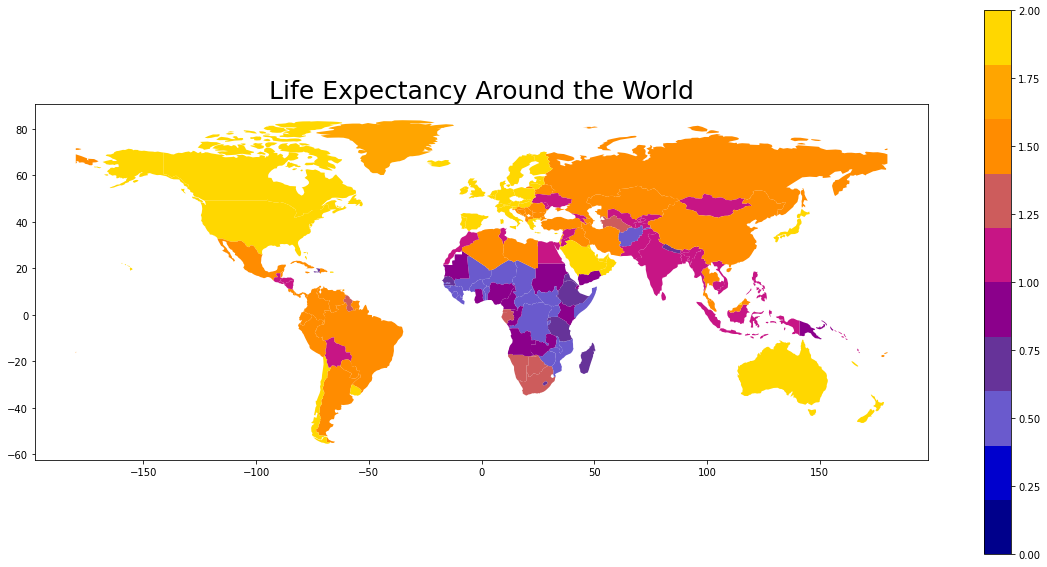

2015


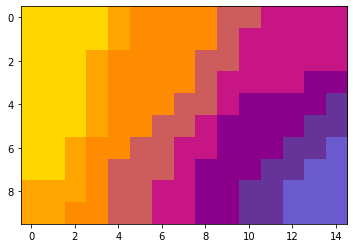

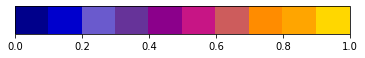

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


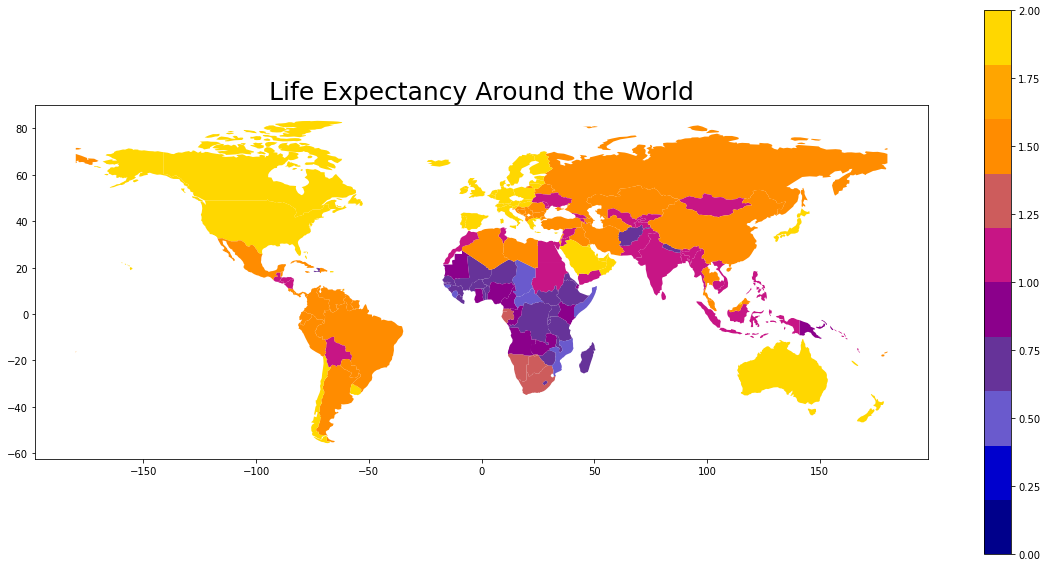

In [ ]:
S = SOM(data, [10, 15], ['Income Group', 'Life Expectancy'],  1000, 0.05, True)
S.somByYear(step=5)